In [1]:
import pandas as pd
import numpy as np
import re
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error
from sklearn import model_selection, pipeline, preprocessing, linear_model
import scipy.stats as stats

import seaborn as sns
%matplotlib inline
%pylab inline
plt.rcParams['figure.dpi'] = 300
sns.set_style("darkgrid")

Populating the interactive namespace from numpy and matplotlib


/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
df = pd.read_pickle('../data/df_all.pkl')
df.head()

,address,days_on_trulia,elementary_school_count,high_school_count,middle_school_count,pets_allowed,price,sqft,url,zip_code,...,demo_pct_two_or_more_races,demo_pct_white,demo_pct_black_or_african_american,demo_pct_american_indian_and_alaska_native,demo_pct_asian,demo_pct_native_hawaiian_and_other_pacific_islander,demo_pct_some_other_race,demo_pct_hispanic_or_latino_(of_any_race),rest_num,n_of_establishments
0,66 West 38th Street Manhattan NY,2,42,12,22,1,3795,None,https://www.trulia.com/p/ny/manhattan/66-w-38t...,10018,...,0.039550,0.591078,0.054936,0.000000,0.293474,0.000000,0.020962,0.165118,2879,6723
1,435 West 45th Street Manhattan NY,2,42,11,22,1,1950,500,https://www.trulia.com/p/ny/manhattan/435-w-45...,10036,...,0.020125,0.642167,0.074845,0.004579,0.192712,0.000000,0.065571,0.177435,1783,6131
2,56 West 11th Street Manhattan NY,14,42,16,19,0,4550,768,https://www.trulia.com/p/ny/manhattan/56-w-11t...,10011,...,0.029680,0.794004,0.045889,0.001270,0.101004,0.000079,0.028073,0.109456,2131,4002
3,298 Mulberry Street Manhattan NY,2,40,13,17,0,5350,None,https://www.trulia.com/p/ny/manhattan/298-mulb...,10012,...,0.038882,0.756643,0.026125,0.001549,0.161355,0.000489,0.014958,0.058730,2328,2972
4,71 West 107th Street Manhattan NY,14,27,6,15,0,2475,None,https://www.trulia.com/p/ny/manhattan/71-w-107...,10025,...,0.041946,0.659955,0.121467,0.008341,0.091821,0.000232,0.076238,0.227076,418,2027


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6342 entries, 0 to 6341
Data columns (total 78 columns):
address                                                6342 non-null object
days_on_trulia                                         6342 non-null int64
elementary_school_count                                6342 non-null int64
high_school_count                                      6342 non-null int64
middle_school_count                                    6342 non-null int64
pets_allowed                                           6342 non-null int64
price                                                  6342 non-null int64
sqft                                                   2318 non-null object
url                                                    6342 non-null object
zip_code                                               6342 non-null int64
evac                                                   1604 non-null object
guarantor                                              6342 non-

In [4]:
# check for nulls
df.columns[df.isna().any()].tolist()

['sqft',
 'evac',
 'pct_high_income',
 'demo_total_population',
 'demo_pct_male',
 'demo_pct_female',
 'demo_pct_under_5_years',
 'demo_pct_5_to_9_years',
 'demo_pct_10_to_14_years',
 'demo_pct_15_to_19_years',
 'demo_pct_20_to_24_years',
 'demo_pct_25_to_34_years',
 'demo_pct_35_to_44_years',
 'demo_pct_45_to_54_years',
 'demo_pct_55_to_59_years',
 'demo_pct_60_to_64_years',
 'demo_pct_65_to_74_years',
 'demo_pct_75_to_84_years',
 'demo_pct_85_years_and_over',
 'demo_pct_18_years_and_over',
 'demo_pct_21_years_and_over',
 'demo_pct_62_years_and_over',
 'demo_pct_65_years_and_over',
 'demo_pct_one_race',
 'demo_pct_two_or_more_races',
 'demo_pct_white',
 'demo_pct_black_or_african_american',
 'demo_pct_american_indian_and_alaska_native',
 'demo_pct_asian',
 'demo_pct_native_hawaiian_and_other_pacific_islander',
 'demo_pct_some_other_race',
 'demo_pct_hispanic_or_latino_(of_any_race)']

In [5]:
# check which zip codes have NULL values
df[pd.isnull(df.demo_total_population)]['zip_code'].unique()

array([11249])

In [6]:
# how many records contain this zip code
df[df['zip_code']==11249]['zip_code'].count()

70

In [7]:
# drop rows containing this zip code
df = df[df.zip_code != 11249].copy()

In [8]:
# check for nulls
df.evac.unique()

array([None, '2', '5', '4', '6', '1', '3', 'c'], dtype=object)

In [9]:
# fix feature name to feed to patsy
df.rename(columns={'flooring:_hardwood': 'flooring_hardwood'}, inplace=True)
df.rename(columns={'off-street_parking': 'off_street_parking'}, inplace=True)
df.rename(columns={'demo_pct_hispanic_or_latino_(of_any_race)': 'demo_pct_hispanic_or_latino'}, inplace=True)

In [10]:
df.loc[:, df.dtypes == object].head()

,address,sqft,url,evac
0,66 West 38th Street Manhattan NY,None,https://www.trulia.com/p/ny/manhattan/66-w-38t...,None
1,435 West 45th Street Manhattan NY,500,https://www.trulia.com/p/ny/manhattan/435-w-45...,None
2,56 West 11th Street Manhattan NY,768,https://www.trulia.com/p/ny/manhattan/56-w-11t...,None
3,298 Mulberry Street Manhattan NY,None,https://www.trulia.com/p/ny/manhattan/298-mulb...,None
4,71 West 107th Street Manhattan NY,None,https://www.trulia.com/p/ny/manhattan/71-w-107...,None


In [11]:
# create a list of all columns not related to demo data
non_demo_cols = [col for col in df.columns if 'demo' not in col]

In [12]:
# create a list with non-numerical columns 
non_num = ['address','url','evac','zip_code']
non_demo_cols = list(set(non_demo_cols).difference(set(non_num)))

# create a list with demo columns
demo_cols = [col for col in df.columns if 'demo' in col]
print('Non-demo columns:', len(non_demo_cols))
print('Demo columns:    ', len(demo_cols))

Non-demo columns: 45
Demo columns:     29


In [13]:
# create of non-demo numerical and booleam column lists
non_demo_num = ['sqft','median_income','middle_school_count','elementary_school_count',
               'high_school_count', 'n_of_establishments', 'rest_num', 'days_on_trulia', 'price', 'pct_high_income']

# create a list of binary columns
non_demo_bool = list(set(non_demo_cols).difference(set(non_demo_num)))

# remove dep var from non_demo_num list
non_demo_num.remove('price')

# remove sqft for now since it countains NULL values
non_demo_num.remove('sqft')

In [14]:
# list of non-binary variables
non_demo_num

['median_income',
 'middle_school_count',
 'elementary_school_count',
 'high_school_count',
 'n_of_establishments',
 'rest_num',
 'days_on_trulia',
 'pct_high_income']

In [15]:
# list of binary variables corresponding to the characteristics of the apartement
non_demo_bool

['washing_machine',
 'off_street_parking',
 'garage',
 'balcony',
 'dishwasher',
 'garden',
 'co_purchase',
 'guarantor',
 'board_approval_required',
 'pets_allowed',
 'deck',
 'sublets',
 'leed_registered',
 'live_in_super',
 'recreation_facilities',
 'courtyard',
 'microwave_oven',
 'cable_tv_ready',
 'elevator',
 'pool',
 'pied_a_terre',
 'fireplace',
 'dryer',
 'pets',
 'concierge',
 'storage',
 'furnished',
 'parents',
 'childrens_playroom',
 'fios_available',
 'fitness_center',
 'air_conditioning',
 'flooring_hardwood',
 'valet_parking',
 'terrace']

In [16]:
# demo variabes from Census data
demo_cols

['demo_total_population',
 'demo_pct_male',
 'demo_pct_female',
 'demo_pct_under_5_years',
 'demo_pct_5_to_9_years',
 'demo_pct_10_to_14_years',
 'demo_pct_15_to_19_years',
 'demo_pct_20_to_24_years',
 'demo_pct_25_to_34_years',
 'demo_pct_35_to_44_years',
 'demo_pct_45_to_54_years',
 'demo_pct_55_to_59_years',
 'demo_pct_60_to_64_years',
 'demo_pct_65_to_74_years',
 'demo_pct_75_to_84_years',
 'demo_pct_85_years_and_over',
 'demo_pct_18_years_and_over',
 'demo_pct_21_years_and_over',
 'demo_pct_62_years_and_over',
 'demo_pct_65_years_and_over',
 'demo_pct_one_race',
 'demo_pct_two_or_more_races',
 'demo_pct_white',
 'demo_pct_black_or_african_american',
 'demo_pct_american_indian_and_alaska_native',
 'demo_pct_asian',
 'demo_pct_native_hawaiian_and_other_pacific_islander',
 'demo_pct_some_other_race',
 'demo_pct_hispanic_or_latino']

In [17]:
# check dep var stats
df.price.describe()

count     6272.000000
mean      2720.768495
std       1542.082094
min        390.000000
25%       1799.000000
50%       2425.000000
75%       3286.500000
max      71850.000000
Name: price, dtype: float64

In [18]:
# see outliers on the high end
df[df.price>10000]

,address,days_on_trulia,elementary_school_count,high_school_count,middle_school_count,pets_allowed,price,sqft,url,zip_code,...,demo_pct_two_or_more_races,demo_pct_white,demo_pct_black_or_african_american,demo_pct_american_indian_and_alaska_native,demo_pct_asian,demo_pct_native_hawaiian_and_other_pacific_islander,demo_pct_some_other_race,demo_pct_hispanic_or_latino,rest_num,n_of_establishments
1059,160 Central Park South Manhattan NY,46,34,9,20,0,12900,750,https://www.trulia.com/p/ny/manhattan/160-cent...,10019,...,0.032907,0.697836,0.064574,0.004961,0.160891,0.001342,0.037489,0.152386,1782,4832
1221,795 5th Avenue New York NY,62,34,9,20,1,20000,975,https://www.trulia.com/p/ny/new-york/795-5th-a...,10065,...,0.011733,0.871571,0.033666,0.000467,0.077631,0.000600,0.004333,0.060631,1573,1492
1355,15 Central Park West Manhattan NY,77,30,10,21,1,11500,"1,342",https://www.trulia.com/p/ny/manhattan/15-centr...,10023,...,0.020993,0.820900,0.034159,0.001841,0.103968,0.000348,0.017792,0.105427,1225,2384
1368,128 East 70th Street Manhattan NY,79,32,9,20,0,10500,None,https://www.trulia.com/p/ny/manhattan/128-e-70...,10021,...,0.034931,0.826517,0.012726,0.006982,0.094563,0.001304,0.022978,0.074148,884,3009
1424,210 East 65th Street New York NY,90,33,8,20,1,11700,643,https://www.trulia.com/p/ny/new-york/210-e-65t...,10065,...,0.011733,0.871571,0.033666,0.000467,0.077631,0.000600,0.004333,0.060631,1112,1492
1537,160 Central Park South Manhattan NY,213,34,9,20,0,11300,791,https://www.trulia.com/p/ny/manhattan/160-cent...,10019,...,0.032907,0.697836,0.064574,0.004961,0.160891,0.001342,0.037489,0.152386,1782,4832
1814,166 Perry Street Manhattan NY,30,45,17,19,1,10500,"1,126",https://www.trulia.com/p/ny/manhattan/166-perr...,10014,...,0.018847,0.889207,0.013253,0.004005,0.056255,0.000000,0.018434,0.068332,1026,2454
1927,7 East 20th Street Manhattan NY,50,43,14,21,1,10900,"2,400",https://www.trulia.com/p/ny/manhattan/7-e-20th...,10003,...,0.028432,0.775116,0.043916,0.001850,0.129441,0.000141,0.021104,0.078743,2153,4318
2026,1 Central Park South Manhattan NY,101,35,10,20,1,12895,None,https://www.trulia.com/p/ny/manhattan/1-centra...,10019,...,0.032907,0.697836,0.064574,0.004961,0.160891,0.001342,0.037489,0.152386,1759,4832
2060,42 West 58th Street Manhattan NY,172,36,10,21,0,71850,"1,500",https://www.trulia.com/p/ny/manhattan/42-w-58t...,10019,...,0.032907,0.697836,0.064574,0.004961,0.160891,0.001342,0.037489,0.152386,1868,4832


In [19]:
# see outliers on the ;ow end
df[df.price<500]

,address,days_on_trulia,elementary_school_count,high_school_count,middle_school_count,pets_allowed,price,sqft,url,zip_code,...,demo_pct_two_or_more_races,demo_pct_white,demo_pct_black_or_african_american,demo_pct_american_indian_and_alaska_native,demo_pct_asian,demo_pct_native_hawaiian_and_other_pacific_islander,demo_pct_some_other_race,demo_pct_hispanic_or_latino,rest_num,n_of_establishments
3496,117 Avenue T Brooklyn NY,19,56,6,35,0,390,None,https://www.trulia.com/rental/4045692209-117-A...,11223,...,0.019441,0.633375,0.041402,0.004979,0.229437,0.002069,0.069296,0.134705,190,2137


In [20]:
df[non_demo_num].describe()

,median_income,middle_school_count,elementary_school_count,high_school_count,n_of_establishments,rest_num,days_on_trulia,pct_high_income
count,6272.000000,6272.000000,6272.00000,6272.000000,6272.000000,6272.000000,6272.000000,6272.000000
mean,77900.886001,19.960938,35.81824,8.689573,2308.647800,843.970823,27.099171,15.028189
std,32224.488307,6.785896,11.23259,4.436418,1656.241665,1118.292186,40.366769,11.589212
min,21553.000000,6.000000,15.00000,2.000000,74.000000,1.000000,-1.000000,0.400000
25%,51864.000000,15.000000,26.00000,5.000000,1079.000000,253.000000,6.000000,4.200000
50%,75362.000000,19.000000,35.00000,8.000000,1967.000000,452.000000,15.000000,10.400000
75%,108178.000000,23.000000,42.00000,12.000000,3015.000000,1180.250000,34.000000,24.900000
max,250001.000000,41.000000,64.00000,28.000000,7373.000000,11931.000000,889.000000,59.900000


In [21]:
# check negative values in 'days on Trulia' 
df.loc[df.days_on_trulia < 0]

,address,days_on_trulia,elementary_school_count,high_school_count,middle_school_count,pets_allowed,price,sqft,url,zip_code,...,demo_pct_two_or_more_races,demo_pct_white,demo_pct_black_or_african_american,demo_pct_american_indian_and_alaska_native,demo_pct_asian,demo_pct_native_hawaiian_and_other_pacific_islander,demo_pct_some_other_race,demo_pct_hispanic_or_latino,rest_num,n_of_establishments
2072,323 East 75th Street Manhattan NY,-1,30,7,19,0,4750,None,https://www.trulia.com/p/ny/manhattan/323-e-75...,10021,...,0.034931,0.826517,0.012726,0.006982,0.094563,0.001304,0.022978,0.074148,739,3009
2073,185 Bleecker Street Manhattan NY,-1,42,14,19,0,3200,None,https://www.trulia.com/p/ny/manhattan/185-blee...,10012,...,0.038882,0.756643,0.026125,0.001549,0.161355,0.000489,0.014958,0.058730,1655,2972
2075,1657 Madison Avenue Manhattan NY,-1,27,6,16,0,1800,None,https://www.trulia.com/p/ny/manhattan/1657-mad...,10029,...,0.026218,0.346891,0.289418,0.002330,0.087041,0.001574,0.246528,0.474065,480,1065
2076,75 East 3rd Street Manhattan NY,-1,40,13,17,0,2750,None,https://www.trulia.com/p/ny/manhattan/75-e-3rd...,10003,...,0.028432,0.775116,0.043916,0.001850,0.129441,0.000141,0.021104,0.078743,1945,4318
2077,330 East 38th Street Manhattan NY,-1,40,14,21,1,3800,763,https://www.trulia.com/p/ny/manhattan/330-e-38...,10016,...,0.038260,0.726072,0.030469,0.001348,0.195702,0.000000,0.008148,0.086056,1383,6042
2078,346 West 36th Street Manhattan NY,-1,42,12,22,1,2000,600,https://www.trulia.com/p/ny/manhattan/346-w-36...,10018,...,0.039550,0.591078,0.054936,0.000000,0.293474,0.000000,0.020962,0.165118,2068,6723
2079,92 Morningside Avenue Manhattan NY,-1,25,4,13,0,3256,None,https://www.trulia.com/p/ny/manhattan/92-morni...,10027,...,0.036385,0.299969,0.414005,0.004757,0.096709,0.000078,0.148097,0.240814,449,1049
2081,328 East 15th Street Manhattan NY,-1,42,16,20,1,2400,700,https://www.trulia.com/p/ny/manhattan/328-e-15...,10003,...,0.028432,0.775116,0.043916,0.001850,0.129441,0.000141,0.021104,0.078743,1516,4318
2082,377 Rector Place Manhattan NY,-1,39,14,19,1,3050,654,https://www.trulia.com/p/ny/manhattan/377-rect...,10280,...,0.028949,0.770340,0.015846,0.000000,0.165566,0.000000,0.019299,0.112443,908,163


In [22]:
# after checking on site, it looks like -1 value was meant to be 1
# change 1 day and 0 days to 1 to be able to put a log on it
df.loc[df.days_on_trulia < 1, 'days_on_trulia'] = 1

# Visualization

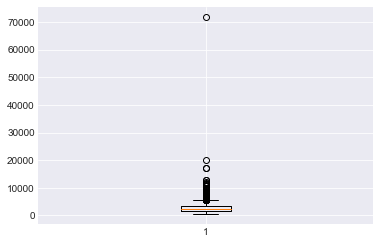

In [23]:
# dep variable distribution
plt.boxplot(df.price);

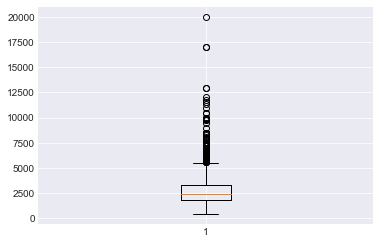

In [24]:
# remove the outlier and plot
df = df[df.price<70000].copy()
# dep variable distribution
plt.boxplot(df.price);

Text(0.5,1,'Monthly 1br Rent Price')

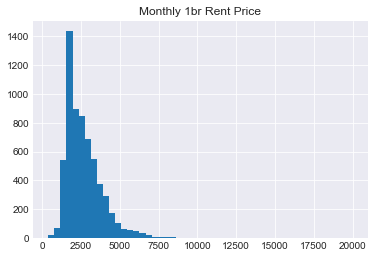

In [25]:
plt.hist(df.price, bins = 50);
plt.title('Monthly 1br Rent Price')

Text(0,0.5,'log scale')

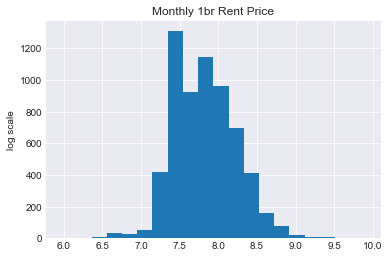

In [26]:
# the data is right-skewed: create a dep var column on a log scale & plot
# df['price_log'] = np.log(df.price)
plt.hist(np.log(df.price), bins = 20);
plt.title('Monthly 1br Rent Price')
plt.ylabel('log scale')

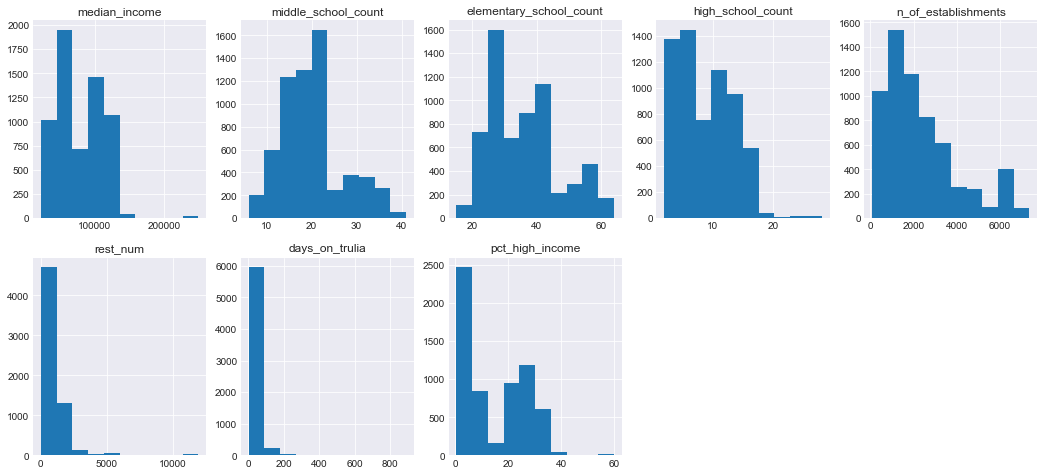

In [27]:
# plot distributions of non-binary variables
plt.figure(figsize=(18, 8))

for var in non_demo_num:
    plt.subplot(2, 5, non_demo_num.index(var)+1)
    plt.hist(df[var])
    plt.title(var);

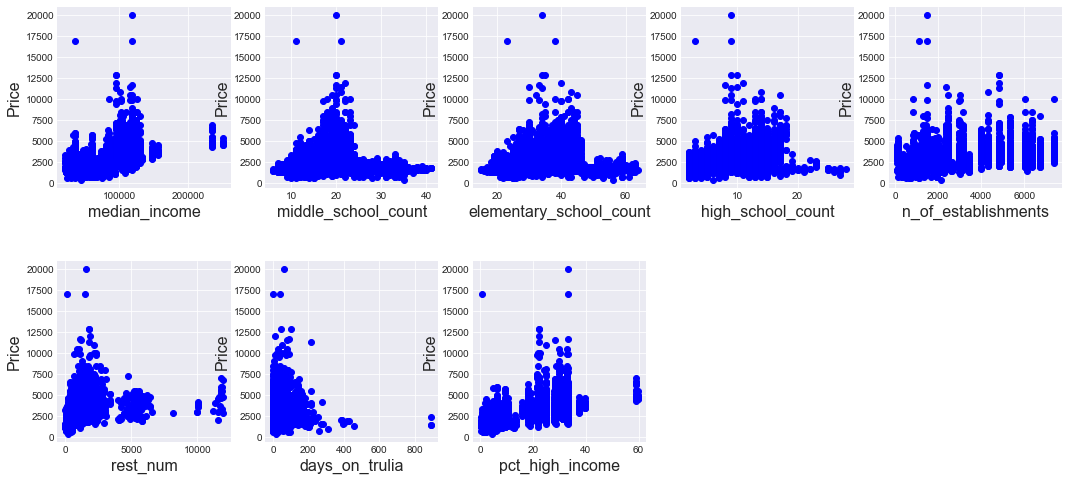

In [28]:
# create scatter plolts with dep var against non_demo_num vars
plt.figure(figsize=(18, 8))
y = df['price']
for var in non_demo_num:
    plt.subplot(2, 5, non_demo_num.index(var)+1)
    plt.plot(df[var], y,'bo')
    plt.subplots_adjust(hspace = 0.4)
    plt.xlabel(var, size = 16)
    plt.ylabel('Price', size=16);

### Observations:
- The number of schools in the neighborhood doesn't seem to be correlated to the price, which is not suprprising for one bedroom apartements

In [29]:
# change highly-skewed variables into log vars
log_vars = ['median_income','pct_high_income','rest_num','days_on_trulia']

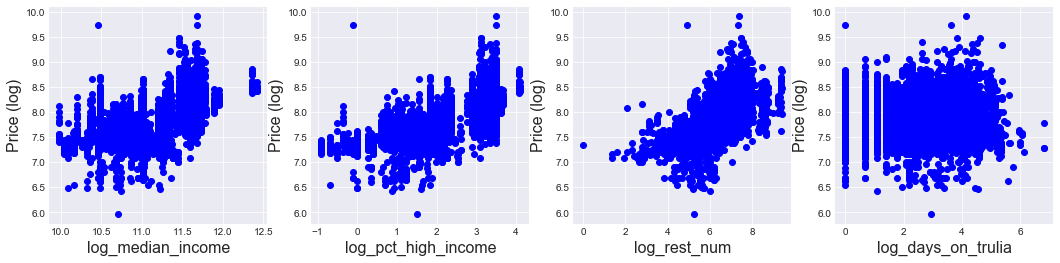

In [30]:
# create scatter plolts with dep var (log) against non_demo_num log-tansformd vars vars
plt.figure(figsize=(18, 4))
y = np.log(df.price)
for var in log_vars:
    plt.subplot(1, 4, log_vars.index(var)+1)
    x_var = np.log(df[var])
    plt.plot(x_var, y,'bo')
    plt.xlabel(f'log_{var}', size = 16)
    plt.ylabel('Price (log)', size = 16);

### Observations:
- Number of restaurants (log rest_num) has positive correlation with apt price <br>
- % of HI households (pct_hight_income) also has a positive correlation with apt price <br>

In [31]:
# school count variables are expected to be multicollinear, let's test that
school_vars = ['middle_school_count', 'elementary_school_count','high_school_count']

df[['middle_school_count', 'elementary_school_count','high_school_count','price']].corr()

,middle_school_count,elementary_school_count,high_school_count,price
middle_school_count,1.000000,0.871883,0.415667,-0.093755
elementary_school_count,0.871883,1.000000,0.593135,0.007522
high_school_count,0.415667,0.593135,1.000000,0.409157
price,-0.093755,0.007522,0.409157,1.000000


### Obesrvations:
- There is a collinearity between elementary school and middle school
- High school has moderate correlation with elementary school
- Our dep var has a very low correlation with school-counts, with the expection of high school

In [32]:
len(non_demo_bool)

35

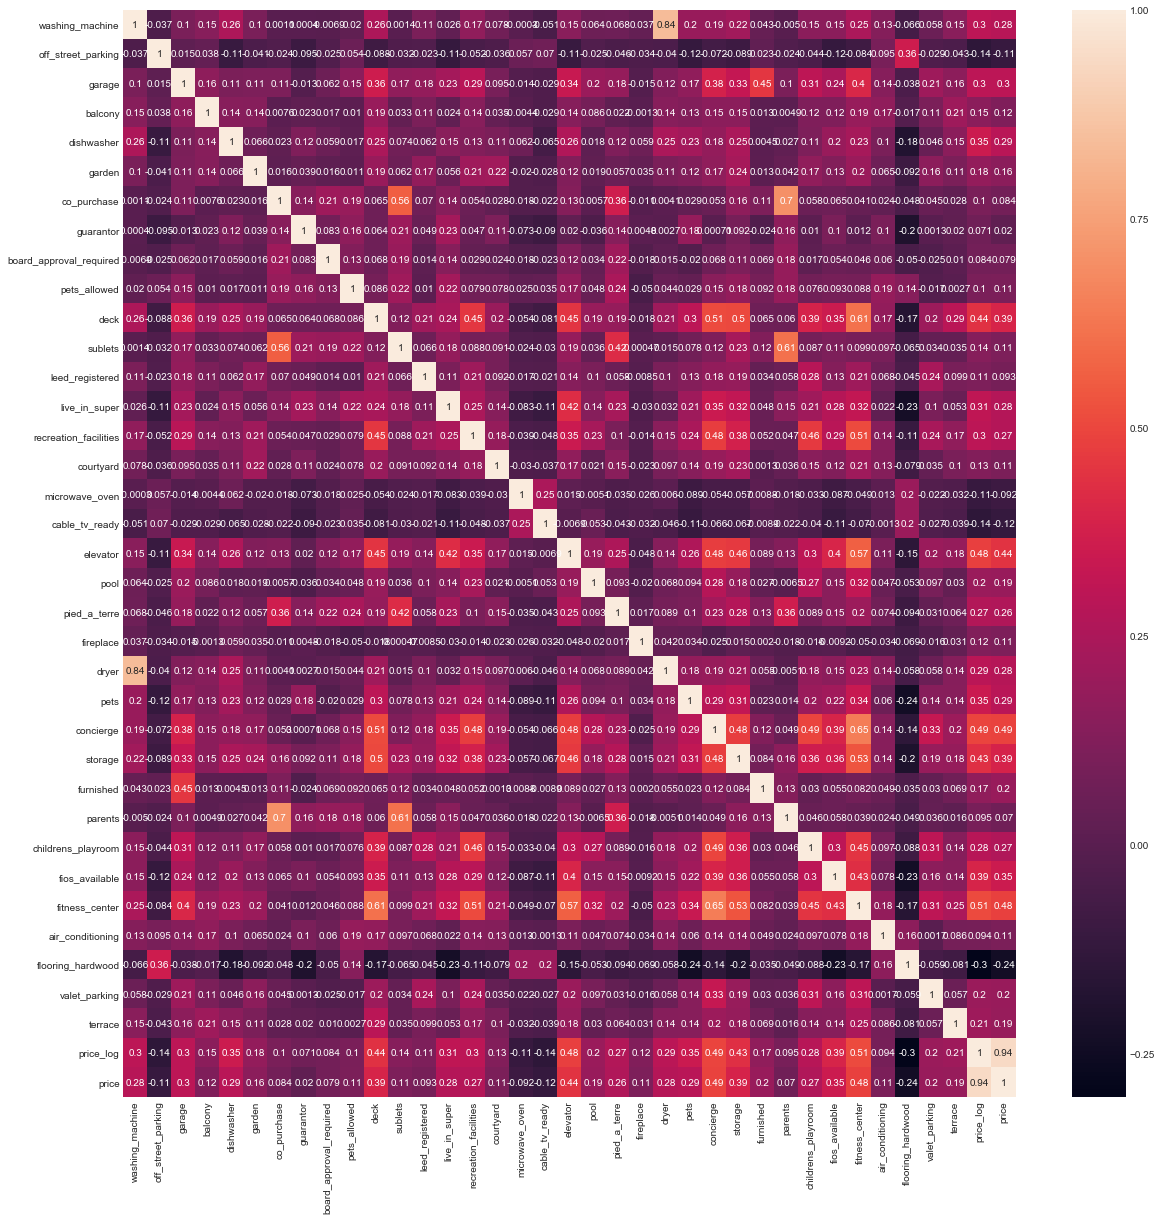

In [33]:
# test correlation between dep var, log-transformed dep var and non-demo binary features
df_test = df[non_demo_bool].copy()

df_test['price_log'] = np.log(df.price).copy()

df_test['price'] = df.price.copy()

df_test.head()

f, ax = plt.subplots(figsize = (20,20))
sns.heatmap(df_test.corr(), annot=True)
plt.show()

### Observations:
- from all features 'fitness center' has the highest correlation with the 1br apt rent price
- concierge, garage, deck and storage also have moderate correlation with rent price
- washing machine should be merged with dryer into one since they are highly correlated features

In [34]:
# merge washing machine and dryer since one comes with another in the apts
df['wash_dry'] = df.loc[(df['washing_machine'] == 1) |  (df['dryer'] == 1), 'wash_dry'] = 1
# drop the other two columns
df.drop(labels = ['washing_machine', 'dryer'], axis=1, inplace=True)
# update non_demo_bool list
non_demo_bool.remove('washing_machine')
non_demo_bool.remove('dryer')
non_demo_bool.append('wash_dry')

# Modeling

# 1. Statsmodels

In [35]:
# split data into test and train 
x = df.drop(labels=['price','address','sqft','url','evac','zip_code'], axis=1)
y = df['price']

X_train , X_test, y_train, y_test = model_selection.train_test_split(x,y, test_size = 0.3)

### Remove outliers from train
### (Tested with outliers in all the models below: test R squared increased by 8% after removing outliers)

In [36]:
# drop outliers from train
X_train['price'] = y_train

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [37]:
X_train['price'].describe()

count     4389.000000
mean      2716.969241
std       1301.983403
min        650.000000
25%       1800.000000
50%       2429.000000
75%       3250.000000
max      20000.000000
Name: price, dtype: float64

In [38]:
price_cut_off = 2709 + 3*1286
price_cut_off

6567

In [39]:
X_train = X_train[X_train.price < 10000].copy()
y_train = X_train['price']
X_train.drop('price', axis = 1, inplace = True)

### 1.1. Test Linear Regression on a subset on non-boolean non-demo features

In [40]:
non_demo_num

['median_income',
 'middle_school_count',
 'elementary_school_count',
 'high_school_count',
 'n_of_establishments',
 'rest_num',
 'days_on_trulia',
 'pct_high_income']

In [41]:
# use patsy on non_demo_num features only
df_train = X_train[non_demo_num].copy()
df_train['price'] = y_train

df_test = X_test[non_demo_num].copy()
df_test['price'] = y_test

# create a string for patsy input
non_demo_num_str = 'price' + ' ~ ' + ' + '.join(non_demo_num)
non_demo_num_str

'price ~ median_income + middle_school_count + elementary_school_count + high_school_count + n_of_establishments + rest_num + days_on_trulia + pct_high_income'

In [42]:
# create feature matrix (X) and target vector (y)
y_sm, X_sm = patsy.dmatrices(non_demo_num_str, data=df_train, return_type="dataframe")
# create model
model = sm.OLS(y_sm, X_sm)
# fit model to training set
fit1 = model.fit()

fit1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.516
Model:                            OLS   Adj. R-squared:                  0.515
Method:                 Least Squares   F-statistic:                     582.2
Date:                Thu, 26 Apr 2018   Prob (F-statistic):               0.00
Time:                        19:59:53   Log-Likelihood:                -35587.
No. Observations:                4377   AIC:                         7.119e+04
Df Residuals:                    4368   BIC:                         7.125e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                1985.9168     66.839     29.712      0.000    1854.879    2116.955
median_income              -0.0086      0.001     -5.778      0.000      -0.012      -0.006
middle_school_count       -16.4886      3.942     -4.183      0.000     -24.217      -8.761
elementary_school_count    -1.3660      2.755     -0.496      0.620      -6.767       4.035
high_school_count          45.5300      4.526     10.060      0.000      36.657      54.403
n_of_establishments         0.0478      0.010      4.568      0.000       0.027       0.068
rest_num                    0.1783      0.014     12.901      0.000       0.151       0.205
days_on_trulia              0.8337      0.311      2.681      0.007       0.224       1.443
pct_high_income            71.2448      4.484     15.890      0.000      62.455      80.035
==============================================================================
Omnibus:                     1704.827   Durbin-Watson:                   2.020
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            12689.218
Skew:                           1.671   Prob(JB):                         0.00
Kurtosis:                      10.643   Cond. No.                     4.54e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.54e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Observations:
- Based on the Skewness number and very high Kurtosis, the values have heavy tails and a single high peak

### 1.2. Run Linear Regression on all features

In [43]:
# use patsy on all features
df_train = X_train.copy()
df_train['price'] = y_train

df_test = X_test.copy()
df_test['price'] = y_test

# create a string for patsy input
all_features_str = 'price' + ' ~ ' + ' + '.join(list(X_train.columns))

# create feature matrix (X) and target vector (y)
y_sm, X_sm = patsy.dmatrices(all_features_str, data=df_train, return_type="dataframe")
# create model
model = sm.OLS(y_sm, X_sm)
# fit model to training set
fit2 = model.fit()

fit2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.683
Model:                            OLS   Adj. R-squared:                  0.678
Method:                 Least Squares   F-statistic:                     140.5
Date:                Thu, 26 Apr 2018   Prob (F-statistic):               0.00
Time:                        19:59:53   Log-Likelihood:                -34663.
No. Observations:                4377   AIC:                         6.946e+04
Df Residuals:                    4310   BIC:                         6.989e+04
Df Model:                          66                                         
Covariance Type:            nonrobust                                         
=======================================================================================================================
                                                          coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------
Intercept                                           -7.275e+09   4.18e+09     -1.741      0.082   -1.55e+10    9.19e+08
days_on_trulia                                          0.5209      0.261      1.999      0.046       0.010       1.032
elementary_school_count                                 6.2445      2.640      2.366      0.018       1.070      11.419
high_school_count                                      22.3120      4.284      5.209      0.000      13.914      30.710
middle_school_count                                   -13.9085      4.087     -3.403      0.001     -21.921      -5.896
pets_allowed                                           64.9389     25.087      2.589      0.010      15.755     114.122
guarantor                                            -146.0622     26.221     -5.570      0.000    -197.468     -94.656
storage                                               103.7768     30.388      3.415      0.001      44.201     163.352
garage                                                -58.5058     35.976     -1.626      0.104    -129.037      12.025
deck                                                  153.3243     34.969      4.385      0.000      84.768     221.881
elevator                                              293.8623     28.469     10.322      0.000     238.049     349.675
dishwasher                                            161.4329     23.863      6.765      0.000     114.649     208.217
pets                                                   82.0106     24.733      3.316      0.001      33.521     130.500
fios_available                                        121.1507     25.941      4.670      0.000      70.294     172.008
live_in_super                                         -95.7607     26.876     -3.563      0.000    -148.451     -43.070
fitness_center                                        257.1950     39.741      6.472      0.000     179.282     335.108
concierge                                             318.7111     43.145      7.387      0.000     234.125     403.298
balcony                                                39.8290     32.802      1.214      0.225     -24.479     104.137
air_conditioning                                      144.1691     34.226      4.212      0.000      77.069     211.269
flooring_hardwood                                      -6.8268     41.449     -0.165      0.869     -88.089      74.435
recreation_facilities                                 -77.1044     46.932     -1.643      0.100    -169.116      14.907
garden                                                138.4972     40.267      3.439      0.001      59.553     217.441
pied_a_terre                                          149.7817     47.897      3.12

### 1.3. Run model on features with p < 0.05

In [44]:
# get a list of features with p-val < 0.05 
low_p_feat = ['days_on_trulia',
'elementary_school_count',
'high_school_count',
'middle_school_count',
'pets_allowed',
'guarantor',
'storage',
'elevator',
'dishwasher',
'pets',
'fios_available',
'live_in_super',
'fitness_center',
'concierge',
'air_conditioning',
'recreation_facilities',
'garden',
'pied_a_terre',
'terrace',
'pool',
'furnished',
'fireplace',
'sublets',
'parents',
'leed_registered',
'median_income',
'pct_high_income',
'demo_total_population',
'demo_pct_18_years_and_over',
'rest_num',
'n_of_establishments']

In [45]:
# model only with features with p-val < 0.05
df_train = X_train[low_p_feat].copy()
df_train['price'] = y_train

df_test = X_test[low_p_feat].copy()
df_test['price'] = y_test

# create a string for patsy input
low_p_feat_str = 'price' + ' ~ ' + ' + '.join(low_p_feat)

# create feature matrix (X) and target vector (y)
y_sm, X_sm = patsy.dmatrices(low_p_feat_str, data=df_train, return_type="dataframe")
# create model
model = sm.OLS(y_sm, X_sm)
# fit model to training set
fit3 = model.fit()

fit3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.669
Model:                            OLS   Adj. R-squared:                  0.666
Method:                 Least Squares   F-statistic:                     283.1
Date:                Thu, 26 Apr 2018   Prob (F-statistic):               0.00
Time:                        19:59:53   Log-Likelihood:                -34756.
No. Observations:                4377   AIC:                         6.958e+04
Df Residuals:                    4345   BIC:                         6.978e+04
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                   -530.2078    244.042     -2.173      0.030   -1008.656     -51.760
days_on_trulia                 0.2655      0.261      1.017      0.309      -0.246       0.777
elementary_school_count        7.4081      2.314      3.201      0.001       2.871      11.945
high_school_count             27.5235      3.922      7.018      0.000      19.835      35.212
middle_school_count          -21.1790      3.325     -6.369      0.000     -27.698     -14.660
pets_allowed                  53.8634     24.796      2.172      0.030       5.251     102.476
guarantor                   -124.7305     26.109     -4.777      0.000    -175.917     -73.544
storage                      135.6072     29.939      4.529      0.000      76.911     194.303
elevator                     270.0262     28.277      9.549      0.000     214.589     325.463
dishwasher                   182.6645     23.654      7.722      0.000     136.290     229.039
pets                         115.3936     24.711      4.670      0.000      66.947     163.840
fios_available               156.1137     25.620      6.093      0.000     105.885     206.342
live_in_super                -98.4021     26.673     -3.689      0.000    -150.696     -46.109
fitness_center               308.6302     38.399      8.037      0.000     233.348     383.912
concierge                    296.9294     41.539      7.148      0.000     215.491     378.368
air_conditioning             150.0526     33.235      4.515      0.000      84.896     215.210
recreation_facilities        -61.5668     45.814     -1.344      0.179    -151.385      28.251
garden                       144.7108     39.933      3.624      0.000      66.421     223.001
pied_a_terre                 147.3675     47.414      3.108      0.002      54.412     240.323
terrace                      187.5297     46.497      4.033      0.000      96.373     278.687
pool                         212.3145     50.838      4.176      0.000     112.645     311.983
furnished                    393.1222     51.722      7.601      0.000     291.720     494.524
fireplace                    301.4524     56.150      5.369      0.000     191.370     411.535
sublets                     -305.6717     76.913     -3.974      0.000    -456.461    -154.883
parents                     -177.4346     96.751     -1.834      0.067    -367.116      12.247
leed_registered             -200.1433     86.957     -2.302      0.021    -370.624     -29.663
median_income                 -0.0097      0.001     -7.579      0.000      -0.012      -0.007
pct_high_income               61.2016      3.789     16.152      0.000      53.773      68.630
demo_total_population          0.0010      0.001      1.785      0.074     -0.0001       0.002
demo_pct_18_years_and_over  2908.2903    29

In [46]:
low_p_feat

['days_on_trulia',
 'elementary_school_count',
 'high_school_count',
 'middle_school_count',
 'pets_allowed',
 'guarantor',
 'storage',
 'elevator',
 'dishwasher',
 'pets',
 'fios_available',
 'live_in_super',
 'fitness_center',
 'concierge',
 'air_conditioning',
 'recreation_facilities',
 'garden',
 'pied_a_terre',
 'terrace',
 'pool',
 'furnished',
 'fireplace',
 'sublets',
 'parents',
 'leed_registered',
 'median_income',
 'pct_high_income',
 'demo_total_population',
 'demo_pct_18_years_and_over',
 'rest_num',
 'n_of_establishments']

### Best model results on non-transformed dep var for future comparison:

In [47]:
# compare test and train scores using sklearn
lr = LinearRegression(fit_intercept=True)
lr.fit(X_train[low_p_feat], y_train)

best_non_log_train = round(lr.score(X_train[low_p_feat], y_train),3)
best_non_log_test = round(lr.score(X_test[low_p_feat], y_test),3)

print('Train score: ', best_non_log_train)
print('Test score: ', best_non_log_test)

Train score:  0.669
Test score:  0.652


Text(0,0.5,'Residiuals')

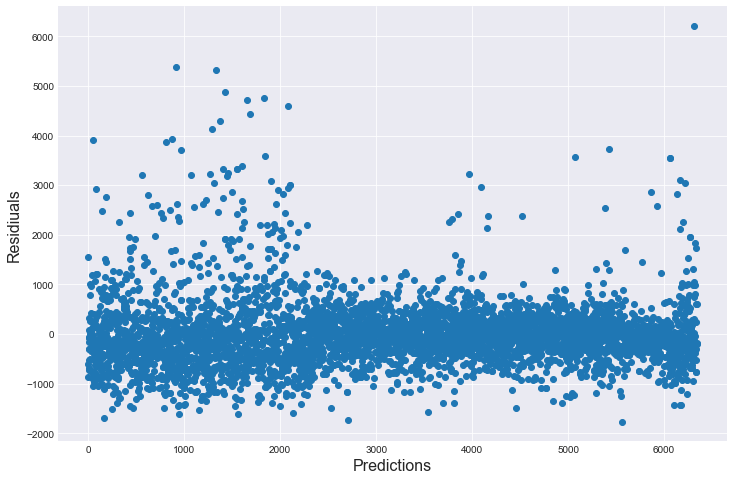

In [48]:
# Plot the residuals
fit3.resid.plot(style='o', figsize=(12,8))
plt.xlabel('Predictions', size = 16)
plt.ylabel('Residiuals', size = 16)

In [49]:
# check residuals against individual features
resids3 = fit3.predict(X_sm) - y_sm.price

In [50]:
log_vars = ['median_income','pct_high_income','rest_num','days_on_trulia']

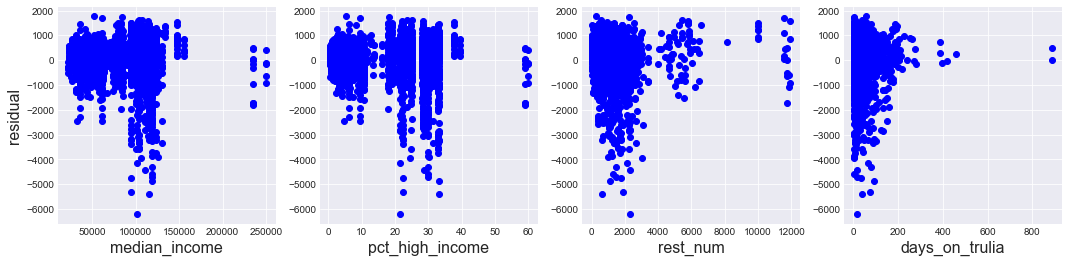

In [51]:
# check if any of the non-normally distributed variables should be transformed based on residual plots
plt.figure(figsize=(18, 4))
for var in log_vars:
    plt.subplot(1, 4, log_vars.index(var)+1)
    plt.plot(X_sm[var],resids3, 'bo')
    plt.xlabel(var, size=16)
    if log_vars.index(var)==0:
        plt.ylabel('residual', size = 16);

### Observations:
- The model is 'missing' when y values are very high. We know that our y is not-normally distributed. Transforming y variable can improve model accuracy

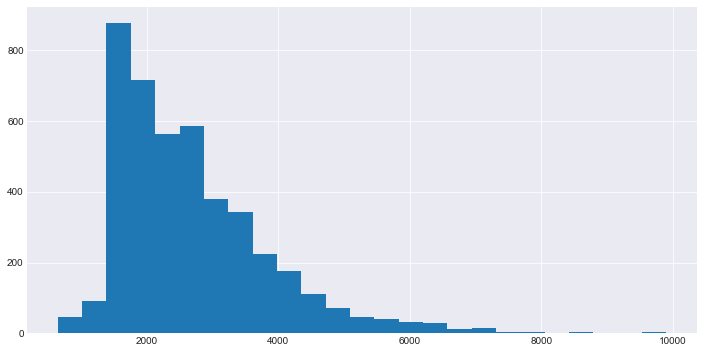

In [52]:
plt.figure(figsize=(12, 6))
plt.hist(y_train,bins=25);

### 1.4. Run the model on log-transformed dep var

In [53]:
# test statmodels on log-transformed dep var
df_train = X_train[low_p_feat].copy()
df_train['price_log'] = np.log(y_train)

df_test = X_test[low_p_feat].copy()
df_test['price_log'] = np.log(y_test)

# create a string for patsy input
low_p_feat_str = 'price_log' + ' ~ ' + ' + '.join(low_p_feat)

# create feature matrix (X) and target vector (y)
y_sm, X_sm = patsy.dmatrices(low_p_feat_str, data=df_train, return_type="dataframe")
# create model
model = sm.OLS(y_sm, X_sm)
# fit model to training set
fit4 = model.fit()

fit4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.749
Model:                            OLS   Adj. R-squared:                  0.747
Method:                 Least Squares   F-statistic:                     418.0
Date:                Thu, 26 Apr 2018   Prob (F-statistic):               0.00
Time:                        19:59:54   Log-Likelihood:                 825.25
No. Observations:                4377   AIC:                            -1587.
Df Residuals:                    4345   BIC:                            -1382.
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      6.3798      0.072     88.680      0.000       6.239       6.521
days_on_trulia              3.755e-05   7.69e-05      0.488      0.626      -0.000       0.000
elementary_school_count        0.0018      0.001      2.662      0.008       0.000       0.003
high_school_count              0.0081      0.001      7.023      0.000       0.006       0.010
middle_school_count           -0.0065      0.001     -6.659      0.000      -0.008      -0.005
pets_allowed                   0.0102      0.007      1.392      0.164      -0.004       0.025
guarantor                     -0.0163      0.008     -2.120      0.034      -0.031      -0.001
storage                        0.0574      0.009      6.504      0.000       0.040       0.075
elevator                       0.0919      0.008     11.026      0.000       0.076       0.108
dishwasher                     0.0827      0.007     11.857      0.000       0.069       0.096
pets                           0.0547      0.007      7.503      0.000       0.040       0.069
fios_available                 0.0599      0.008      7.925      0.000       0.045       0.075
live_in_super                 -0.0349      0.008     -4.443      0.000      -0.050      -0.020
fitness_center                 0.1078      0.011      9.520      0.000       0.086       0.130
concierge                      0.0493      0.012      4.025      0.000       0.025       0.073
air_conditioning               0.0264      0.010      2.695      0.007       0.007       0.046
recreation_facilities         -0.0071      0.014     -0.529      0.597      -0.034       0.019
garden                         0.0620      0.012      5.263      0.000       0.039       0.085
pied_a_terre                   0.0247      0.014      1.764      0.078      -0.003       0.052
terrace                        0.0696      0.014      5.077      0.000       0.043       0.096
pool                           0.0738      0.015      4.927      0.000       0.044       0.103
furnished                      0.0770      0.015      5.052      0.000       0.047       0.107
fireplace                      0.0972      0.017      5.874      0.000       0.065       0.130
sublets                       -0.0715      0.023     -3.152      0.002      -0.116      -0.027
parents                       -0.0396      0.029     -1.388      0.165      -0.095       0.016
leed_registered               -0.0545      0.026     -2.126      0.034      -0.105      -0.004
median_income              -4.144e-06   3.76e-07    -11.014      0.000   -4.88e-06   -3.41e-06
pct_high_income                0.0239      0.001     21.437      0.000       0.022       0.026
demo_total_population       3.648e-07   1.68e-07      2.171      0.030    3.53e-08    6.94e-07
demo_pct_18_years_and_over     1.4435      

### 1.5. Run model on log-transformed dep var using features with p < 0.05

In [54]:
# create a list of features with p < 0.05 that came out of log-transformed dep var model
low_p_feat_log = ['elementary_school_count',
'high_school_count',
'middle_school_count',
'guarantor',
'storage',
'elevator',
'dishwasher',
'pets',
'fios_available',
'live_in_super',
'fitness_center',
'concierge',
'air_conditioning',
'garden',
'terrace',
'pool',
'furnished',
'fireplace',
'median_income',
'pct_high_income',
'demo_total_population',
'demo_pct_18_years_and_over',
'rest_num',
'n_of_establishments']

In [55]:
df_train = X_train[low_p_feat_log].copy()
df_train['price_log'] = np.log(y_train)

df_test = X_test[low_p_feat_log].copy()
df_test['price_log'] = np.log(y_test)

# create a string for patsy input
low_p_feat_log_str = 'price_log' + ' ~ ' + ' + '.join(low_p_feat_log)

# create feature matrix (X) and target vector (y)
y_sm, X_sm = patsy.dmatrices(low_p_feat_log_str, data=df_train, return_type="dataframe")
# create model
model = sm.OLS(y_sm, X_sm)
# fit model to training set
fit5 = model.fit()

fit5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.747
Model:                            OLS   Adj. R-squared:                  0.746
Method:                 Least Squares   F-statistic:                     536.0
Date:                Thu, 26 Apr 2018   Prob (F-statistic):               0.00
Time:                        19:59:54   Log-Likelihood:                 810.61
No. Observations:                4377   AIC:                            -1571.
Df Residuals:                    4352   BIC:                            -1412.
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      6.3975      0.072     89.368      0.000       6.257       6.538
elementary_school_count        0.0017      0.001      2.543      0.011       0.000       0.003
high_school_count              0.0080      0.001      6.945      0.000       0.006       0.010
middle_school_count           -0.0063      0.001     -6.455      0.000      -0.008      -0.004
guarantor                     -0.0208      0.008     -2.755      0.006      -0.036      -0.006
storage                        0.0528      0.009      6.105      0.000       0.036       0.070
elevator                       0.0902      0.008     10.874      0.000       0.074       0.106
dishwasher                     0.0830      0.007     11.906      0.000       0.069       0.097
pets                           0.0545      0.007      7.512      0.000       0.040       0.069
fios_available                 0.0597      0.008      7.912      0.000       0.045       0.075
live_in_super                 -0.0354      0.008     -4.556      0.000      -0.051      -0.020
fitness_center                 0.1070      0.011      9.662      0.000       0.085       0.129
concierge                      0.0515      0.012      4.303      0.000       0.028       0.075
air_conditioning               0.0270      0.010      2.792      0.005       0.008       0.046
garden                         0.0573      0.012      4.923      0.000       0.034       0.080
terrace                        0.0704      0.014      5.134      0.000       0.044       0.097
pool                           0.0737      0.015      4.933      0.000       0.044       0.103
furnished                      0.0738      0.015      4.879      0.000       0.044       0.103
fireplace                      0.0978      0.017      5.894      0.000       0.065       0.130
median_income              -4.196e-06   3.76e-07    -11.145      0.000   -4.93e-06   -3.46e-06
pct_high_income                0.0242      0.001     21.617      0.000       0.022       0.026
demo_total_population       3.687e-07   1.68e-07      2.191      0.029    3.87e-08    6.99e-07
demo_pct_18_years_and_over     1.4290      0.087     16.502      0.000       1.259       1.599
rest_num                    2.898e-05   3.51e-06      8.249      0.000    2.21e-05    3.59e-05
n_of_establishments         -8.61e-06   2.86e-06     -3.012      0.003   -1.42e-05   -3.01e-06
==============================================================================
Omnibus:                      291.521   Durbin-Watson:                   2.015
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1050.162
Skew:                           0.258   Prob(JB):                    9.12e-229
Kurtosis:                       5.344   Cond. No.                     3.56e+06
============================

Text(0,0.5,'Residiuals')

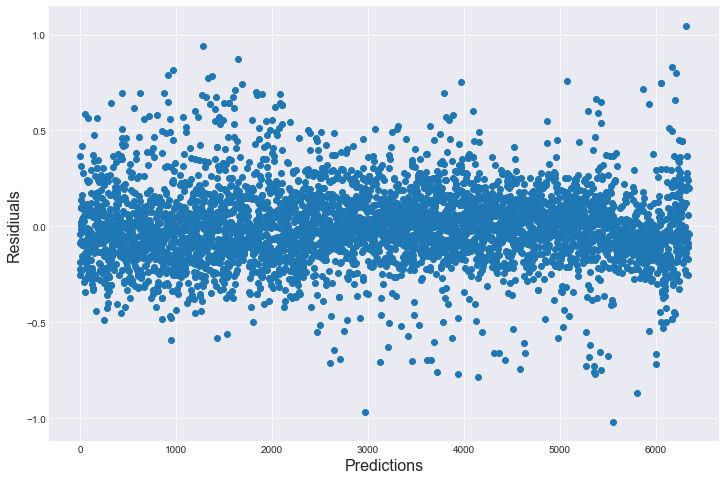

In [56]:
# Plot the residuals
fit5.resid.plot(style='o', figsize=(12,8))
plt.xlabel('Predictions', size = 16)
plt.ylabel('Residiuals', size = 16)

### Observations:
- The residuals are 'clustered' tighter around zero compared to the previous models

In [57]:
# compare test and train scores using sklearn
lr = LinearRegression(fit_intercept=True,)
lr.fit(X_train[low_p_feat_log], np.log(y_train))

print('Train score: ', round(lr.score(X_train[low_p_feat_log], np.log(y_train)),3))
print('Test score: ', round(lr.score(X_test[low_p_feat_log], np.log(y_test)),3))

Train score:  0.747
Test score:  0.728


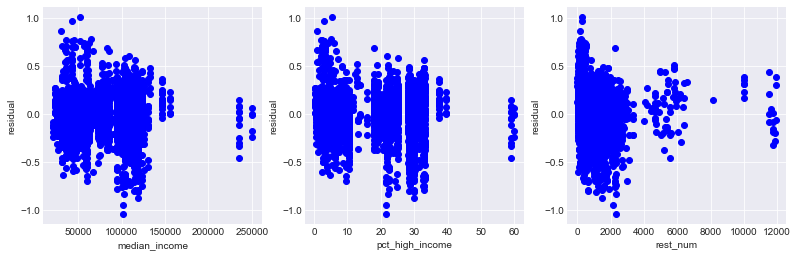

In [58]:
# another check of residuals on the non-normally distributed variables 
resids5 = fit5.predict(X_sm) - y_sm.price_log

plt.figure(figsize=(18, 4))
for var in log_vars:
    if var in list(X_sm.columns):
        plt.subplot(1, 4, log_vars.index(var)+1)
        plt.plot(X_sm[var],resids5, 'bo')
        plt.xlabel(var)
        plt.ylabel('residual');

### Observations:
- It looks like the models is still missing when y_var values are very high, while residuals on high x_vars are normally distibuted around zero

### 1.6. Test log-transformed x-vars with log-stansformed dep var and top features

In [59]:
vars_to_be_log = []
for var in log_vars:
    if var in low_p_feat_log:
        vars_to_be_log.append(var)

In [60]:
vars_to_be_log

['median_income', 'pct_high_income', 'rest_num']

In [61]:
# Still check model results when log-transforming x_vars

def test_log_vars(variable_str):
    df_train = X_train[low_p_feat_log].copy()
    df_train['price_log'] = np.log(y_train)

    df_test = X_test[low_p_feat_log].copy()
    df_test['price_log'] = np.log(y_test)
    
    # log-transform var
    df_train[variable_str] = np.log(df_train[variable_str])
    df_test[variable_str] = np.log(df_test[variable_str])

    # create a string for patsy input
    low_p_feat_log_str = 'price_log' + ' ~ ' + ' + '.join(low_p_feat_log)

    # create feature matrix (X) and target vector (y)
    y_sm, X_sm = patsy.dmatrices(low_p_feat_log_str, data=df_train, return_type="dataframe")
    # create model
    model = sm.OLS(y_sm, X_sm)
    # fit model to training set
    fit6 = model.fit()
    
    lr = LinearRegression(fit_intercept=True,)
    lr.fit(df_train.drop('price_log', axis=1), df_train['price_log'])

    train_score = round(lr.score(df_train.drop('price_log', axis=1), df_train['price_log']),3)
    test_score = round(lr.score(df_test.drop('price_log', axis=1), df_test['price_log']),3)

    print('Logged var:', var)
    print('Train score:', train_score)
    print('Test score:', test_score)

In [62]:
for var in vars_to_be_log:
    test_log_vars(var)
    print('\n')

Logged var: median_income
Train score: 0.744
Test score: 0.725


Logged var: pct_high_income
Train score: 0.733
Test score: 0.717


Logged var: rest_num
Train score: 0.755
Test score: 0.737




### Observations:
- Compared to the model ran on non-transformed features only restaurant number transformation slightly improved R squared

### 1.7. Check summary stats with log-transformed restaurant number feature

In [63]:
# log-transform rest_num
# remove elementary school count since its p-val was > 0.05

df_train = X_train[low_p_feat_log].copy()
df_train['price_log'] = np.log(y_train)
df_train['rest_num'] = np.log(df_train['rest_num'])
df_train.drop('elementary_school_count', axis=1, inplace=True)

df_test = X_test[low_p_feat_log].copy()
df_test['price_log'] = np.log(y_test)
df_test['rest_num'] = np.log(df_test['rest_num'])
df_test.drop('elementary_school_count', axis=1, inplace=True)

# create a string for patsy input
low_p_feat_log.remove('elementary_school_count')
low_p_feat_log_str = 'price_log' + ' ~ ' + ' + '.join(low_p_feat_log)

# create feature matrix (X) and target vector (y)
y_sm, X_sm = patsy.dmatrices(low_p_feat_log_str, data=df_train, return_type="dataframe")
# create model
model = sm.OLS(y_sm, X_sm)
# fit model to training set
fit7 = model.fit()

fit7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.755
Model:                            OLS   Adj. R-squared:                  0.753
Method:                 Least Squares   F-statistic:                     582.3
Date:                Thu, 26 Apr 2018   Prob (F-statistic):               0.00
Time:                        19:59:56   Log-Likelihood:                 876.36
No. Observations:                4377   AIC:                            -1705.
Df Residuals:                    4353   BIC:                            -1551.
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      6.2986      0.069     90.914      0.000       6.163       6.434
high_school_count              0.0110      0.001     11.317      0.000       0.009       0.013
middle_school_count           -0.0036      0.001     -6.243      0.000      -0.005      -0.002
guarantor                     -0.0222      0.007     -2.998      0.003      -0.037      -0.008
storage                        0.0492      0.009      5.785      0.000       0.033       0.066
elevator                       0.0898      0.008     11.004      0.000       0.074       0.106
dishwasher                     0.0805      0.007     11.710      0.000       0.067       0.094
pets                           0.0471      0.007      6.561      0.000       0.033       0.061
fios_available                 0.0554      0.007      7.443      0.000       0.041       0.070
live_in_super                 -0.0371      0.008     -4.842      0.000      -0.052      -0.022
fitness_center                 0.1034      0.011      9.478      0.000       0.082       0.125
concierge                      0.0558      0.012      4.749      0.000       0.033       0.079
air_conditioning               0.0313      0.010      3.295      0.001       0.013       0.050
garden                         0.0594      0.011      5.180      0.000       0.037       0.082
terrace                        0.0683      0.014      5.058      0.000       0.042       0.095
pool                           0.0755      0.015      5.135      0.000       0.047       0.104
furnished                      0.0710      0.015      4.769      0.000       0.042       0.100
fireplace                      0.0991      0.016      6.066      0.000       0.067       0.131
median_income              -2.848e-06   3.81e-07     -7.465      0.000    -3.6e-06    -2.1e-06
pct_high_income                0.0191      0.001     16.796      0.000       0.017       0.021
demo_total_population       2.682e-07   1.66e-07      1.617      0.106   -5.69e-08    5.93e-07
demo_pct_18_years_and_over     1.0004      0.092     10.858      0.000       0.820       1.181
rest_num                       0.0735      0.005     14.560      0.000       0.064       0.083
n_of_establishments        -1.362e-05   2.82e-06     -4.831      0.000   -1.91e-05   -8.09e-06
==============================================================================
Omnibus:                      298.335   Durbin-Watson:                   2.013
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1207.675
Skew:                           0.215   Prob(JB):                    5.71e-263
Kurtosis:                       5.537   Cond. No.                     3.63e+06
==============================================================================

Warnings:
[1] Standard Errors assume that t

Text(0,0.5,'Residiuals')

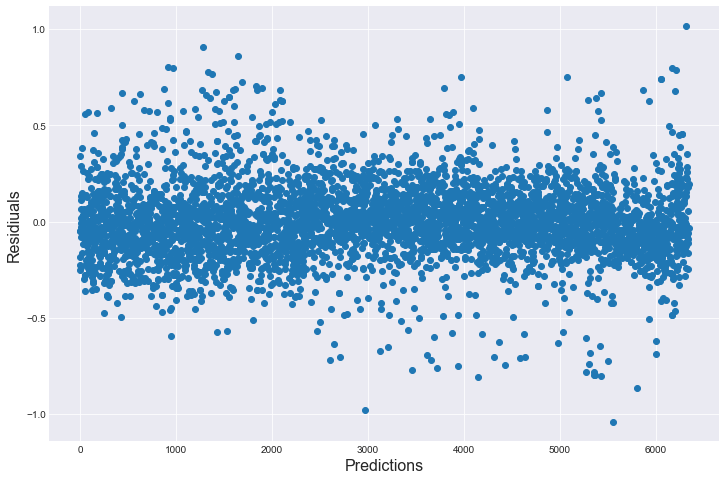

In [64]:
# Plot the residuals
fit7.resid.plot(style='o', figsize=(12,8))
plt.xlabel('Predictions', size = 16)
plt.ylabel('Residiuals', size = 16)

In [65]:
# get residuals
resids7 = fit7.predict(X_sm) - y_sm.price_log

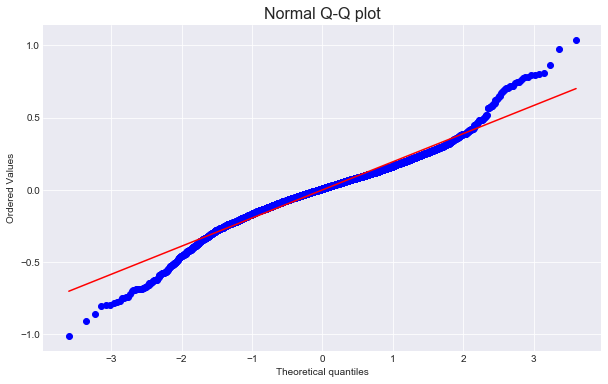

In [66]:
figsize(10,6)
stats.probplot(resids7, dist="norm", plot=plt)
plt.title("Normal Q-Q plot", size=16)
plt.xticks(size=10)
plt.yticks(size=10);

In [67]:
from sklearn.metrics import r2_score

In [68]:
x_train_fit7 = df_train.drop('price_log', axis=1)
x_test_fit7 = df_test.drop('price_log', axis=1)

lr = LinearRegression(fit_intercept=True,)
lr.fit(x_train_fit7, df_train['price_log'])

print('Train: ', round(lr.score(x_train_fit7, df_train['price_log']),3))
print('Test: ', round(lr.score(x_test_fit7, df_test['price_log']),3))

Train:  0.755
Test:  0.737


### Check model performance on exponentiated dep var

In [69]:
print('Train: ',  round(r2_score(y_train, np.exp(lr.predict(x_train_fit7))), 3))
print('Test: ', round(r2_score(y_test, np.exp(lr.predict(x_test_fit7))), 3))

Train:  0.674
Test:  0.656


#### Compare with:

In [70]:
print('Non-transformed dep-var train score: ', best_non_log_train)
print('Non-transformed dep-var test score: ', best_non_log_test)

Non-transformed dep-var train score:  0.669
Non-transformed dep-var test score:  0.652


# 2. Moving to Sklearn

In [71]:
import warnings
warnings.filterwarnings("ignore")

In [72]:
from sklearn import pipeline, feature_selection, model_selection, linear_model, preprocessing

In [73]:
df_sklearn = df.select_dtypes(["float64", "int64"]).copy()
df_sklearn.head()

,days_on_trulia,elementary_school_count,high_school_count,middle_school_count,pets_allowed,price,zip_code,guarantor,storage,garage,...,demo_pct_white,demo_pct_black_or_african_american,demo_pct_american_indian_and_alaska_native,demo_pct_asian,demo_pct_native_hawaiian_and_other_pacific_islander,demo_pct_some_other_race,demo_pct_hispanic_or_latino,rest_num,n_of_establishments,wash_dry
0,2,42,12,22,1,3795,10018,0,1,0,...,0.591078,0.054936,0.000000,0.293474,0.000000,0.020962,0.165118,2879,6723,1
1,2,42,11,22,1,1950,10036,1,0,0,...,0.642167,0.074845,0.004579,0.192712,0.000000,0.065571,0.177435,1783,6131,1
2,14,42,16,19,0,4550,10011,1,0,0,...,0.794004,0.045889,0.001270,0.101004,0.000079,0.028073,0.109456,2131,4002,1
3,2,40,13,17,0,5350,10012,0,0,0,...,0.756643,0.026125,0.001549,0.161355,0.000489,0.014958,0.058730,2328,2972,1
4,14,27,6,15,0,2475,10025,0,0,0,...,0.659955,0.121467,0.008341,0.091821,0.000232,0.076238,0.227076,418,2027,1


In [74]:
x = df_sklearn.drop(columns=["price", "zip_code"]).copy()
y = df_sklearn["price"]

### 2.1. KBest

In [75]:
select_pipe = pipeline.Pipeline(
    [("std", preprocessing.StandardScaler()),
     ("select",
      feature_selection.SelectKBest(
          score_func=feature_selection.f_regression)), 
     ("lin", linear_model.LinearRegression())
])

In [76]:
cv_result = model_selection.cross_validate(
        select_pipe, X=x, y=y, cv=10, return_train_score=True)
print(f"train: {np.mean(cv_result['train_score']):.3}, test: {np.mean(cv_result['test_score']):.3}")

train: 0.564, test: 0.482


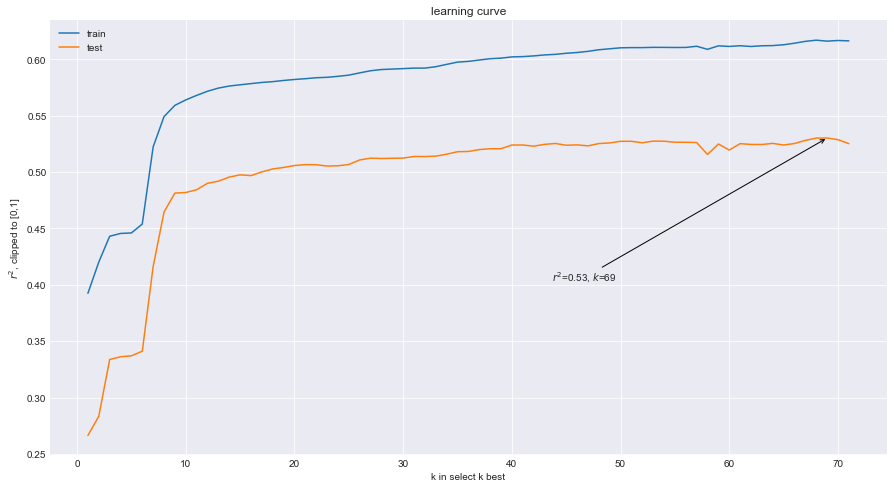

In [77]:
figsize(15, 8)


train_scores = []
test_scores = []
# define feature range
num_feats = len(x.columns)
feat_range = np.arange(num_feats)+1
# for each k in feat_range
for num_f in feat_range:
    # set pipeline params
    select_pipe.set_params(select__k=num_f)
    # get cross val scores
    cv_result = model_selection.cross_validate(
        select_pipe, X=x, y=y, cv=10, return_train_score=True)
    train_scores.append(np.maximum(np.mean(cv_result['train_score']), 0))
    test_scores.append(np.maximum(np.mean(cv_result['test_score']), 0))

# plot test vs train
plot(feat_range, train_scores, label="train")
plot(feat_range, test_scores, label="test")

# find index of best score
best_i = np.argmax(test_scores)
# annotate score
ann_xy = (feat_range[best_i], test_scores[best_i])
ann_text = f"$r^2$={test_scores[best_i]:.2}, $k$={feat_range[best_i]}"
annotate(ann_text, xy=ann_xy, xytext=(.6,.4), textcoords='axes fraction',
            arrowprops=dict(arrowstyle="->"),
            )

xlabel("k in select k best")
ylabel("$r^2$, clipped to [0,1]")
title("learning curve")
legend();

### 2.2. Ridge

In [78]:
ridge_pipe = pipeline.Pipeline([
     ("std", preprocessing.StandardScaler()),
     ("var", feature_selection.VarianceThreshold()), 
     ("ridge", linear_model.Ridge())
    ])

In [79]:
x_train, x_test, y_train, y_test  = model_selection.train_test_split(x,y)

In [80]:
alphas = np.logspace(.1, 10, num=100)
coefs = []
train_scores = []
test_scores = []


for i, alpha in enumerate(alphas):
    ridge_pipe.set_params(ridge__alpha=alpha)
    cv_result = model_selection.cross_validate(
        ridge_pipe, X=x, y=y, cv=10, return_train_score=True)
    train_scores.append(np.maximum(np.mean(cv_result['train_score']), 0))
    test_scores.append(np.maximum(np.mean(cv_result['test_score']), 0))
    
    ridge_pipe.fit(x_train, y_train)
    coefs.append(ridge_pipe.named_steps["ridge"].coef_)

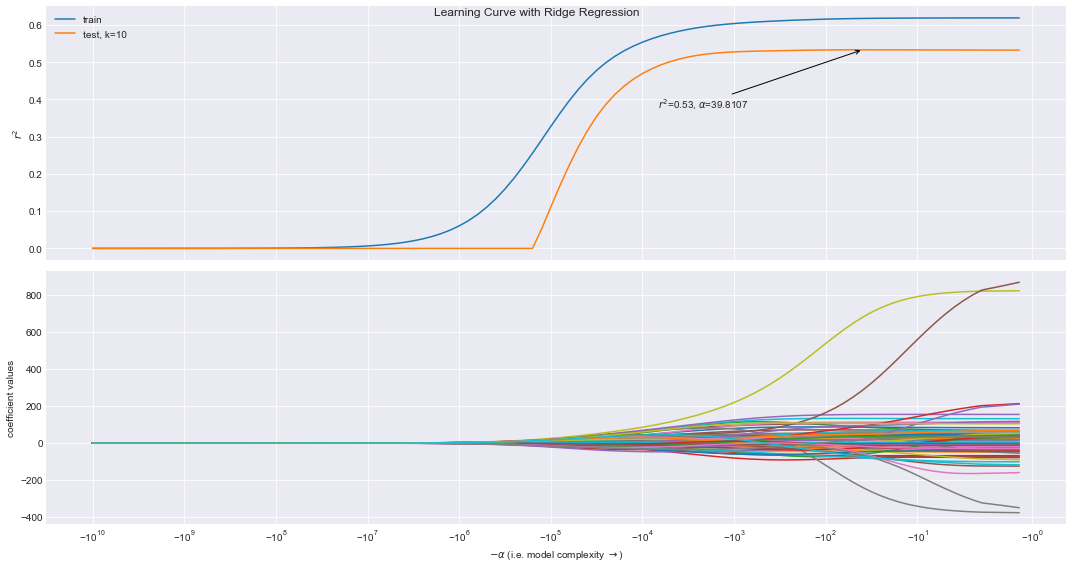

In [81]:
fig, axes = plt.subplots(2, 1, figsize=(15, 8), sharex=True, tight_layout=True)
coef_arr = np.squeeze(coefs, axis=1)
ax0 = axes.flat[0]
ax0.plot(-alphas, train_scores, label="train")
ax0.plot(-alphas, test_scores, label="test, k=10")
best_i = np.argmax(test_scores)
ann_xy = (-alphas[best_i], test_scores[best_i])
ann_text = f"$r^2$={test_scores[best_i]:.2}, $\\alpha$={alphas[best_i]:g}"
ax0.annotate(ann_text, xy=ann_xy, xytext=(.6,.6), textcoords='axes fraction',
            arrowprops=dict(arrowstyle="->"),
            )
ax0.set_ylabel("$r^2$")
ax0.legend()

ax1 = axes.flat[1]
ax1.plot(-alphas, coef_arr)
ax1.set_ylabel("coefficient values")
ax1.set_xlabel("$-\\alpha$ (i.e. model complexity $\\rightarrow$)")
fig.suptitle("Learning Curve with Ridge Regression")
plt.xscale("symlog")
plt.savefig("trulia_ridge.pdf")

### 2.3. Lasso

In [82]:
lasso_pipe = pipeline.Pipeline([
     ("imp", preprocessing.Imputer()), 
     ("std", preprocessing.StandardScaler()),
     ("var", feature_selection.VarianceThreshold()), 
     ("lasso", linear_model.Lasso())
    ])

In [83]:
alphas = np.logspace(.1, 10, num=100)
coefs = []
train_scores = []
test_scores = []

for i, alpha in enumerate(alphas):
    lasso_pipe.set_params(lasso__alpha=alpha)
    cv_result = model_selection.cross_validate(
        lasso_pipe, X=x, y=y, cv=10, return_train_score=True)
    train_scores.append(np.maximum(np.mean(cv_result['train_score']), 0))
    test_scores.append(np.maximum(np.mean(cv_result['test_score']), 0))

    lasso_pipe.fit(x_train, y_train)
    coefs.append(lasso_pipe.named_steps["lasso"].coef_)

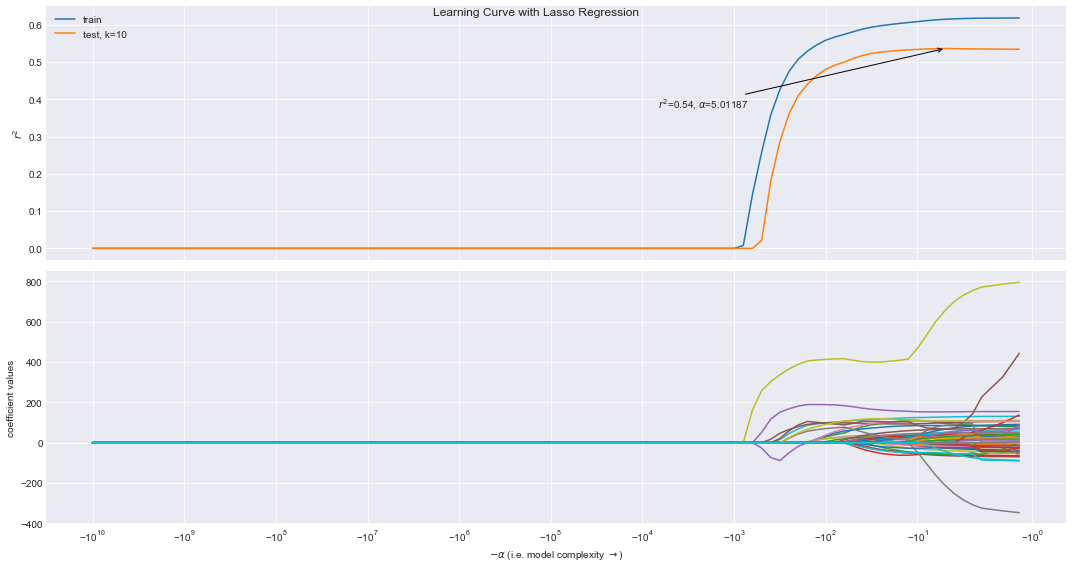

In [84]:
fig, axes = plt.subplots(2, 1, figsize=(15, 8), sharex=True, tight_layout=True)
coef_arr = np.squeeze(coefs, axis=1)
ax0 = axes.flat[0]
ax0.plot(-alphas, train_scores, label="train")
ax0.plot(-alphas, test_scores, label="test, k=10")
best_i = np.argmax(test_scores)
ann_xy = (-alphas[best_i], test_scores[best_i])
ann_text = f"$r^2$={test_scores[best_i]:.2}, $\\alpha$={alphas[best_i]:g}"
ax0.annotate(ann_text, xy=ann_xy, xytext=(.6,.6), textcoords='axes fraction',
            arrowprops=dict(arrowstyle="->"),
            )
ax0.set_ylabel("$r^2$")
ax0.legend()

ax1 = axes.flat[1]
ax1.plot(-alphas, coef_arr)
ax1.set_ylabel("coefficient values")
ax1.set_xlabel("$-\\alpha$ (i.e. model complexity $\\rightarrow$)")
fig.suptitle("Learning Curve with Lasso Regression")
plt.xscale("symlog")
plt.savefig("trulia_lasso.pdf")

In [85]:
var_support = lasso_pipe.named_steps["var"].get_support()
feat = x.columns[var_support]
coef = coefs[best_i]
sort_i = argsort(-np.abs(coef))

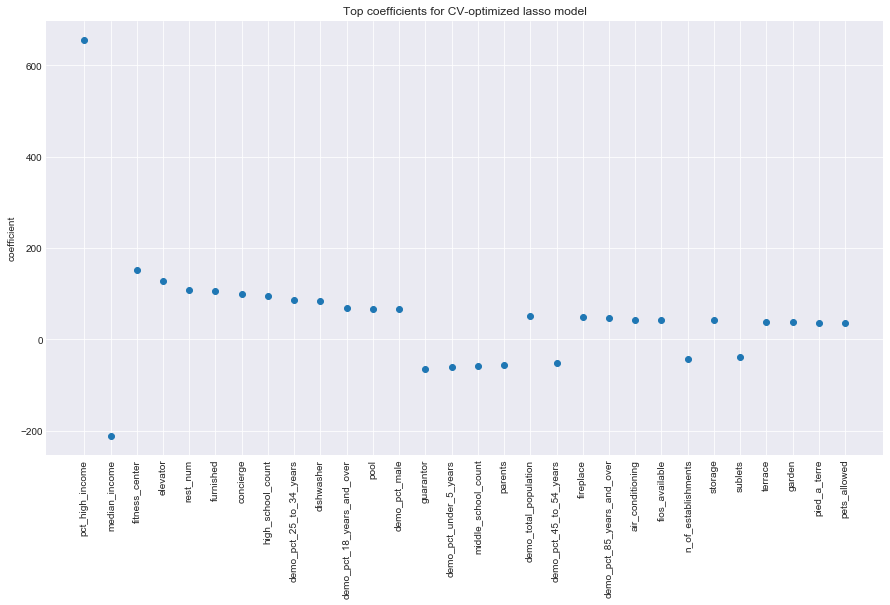

In [86]:
figsize(15,8)
n_plot = 30
ind = np.arange(n_plot)

scatter(ind, coef[sort_i][:n_plot])
plt.xticks(ind, feat[sort_i][:n_plot], rotation=90);
plt.title("Top coefficients for CV-optimized lasso model")
plt.ylabel("coefficient");